## Face landmark
- This is an ipynb file created in Kaggle environment.
- CNN

#### Dataset
- Face Images with Marked Landmark Points, https://www.kaggle.com/drgilermo/face-images-with-marked-landmark-points

## 0. Import Packages

In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam

## 1. Make dataset

In [17]:
# let's deal with .npz type of image file
img = np.load('/kaggle/input/face-images-with-marked-landmark-points/face_images.npz')  # class
face = img.get(img.files[0])  # image to array (96, 96, 7049)
face = np.moveaxis(face,-1,0)  # (7049, 96, 96)
face = face.reshape(face.shape[0],face.shape[1],face.shape[1], 1)

print(face.shape)

(7049, 96, 96, 1)


In [18]:
key_pts = pd.read_csv('/kaggle/input/face-images-with-marked-landmark-points/facial_keypoints.csv')
key_pts.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [19]:
print(key_pts.shape)

(7049, 30)


In [20]:
key_pts = key_pts.fillna(0)

In [21]:
key_pts.index.values

array([   0,    1,    2, ..., 7046, 7047, 7048])

In [22]:
features = face[key_pts.index.values, :, :, :]
features = features/255  # normalize
key_pts.reset_index(inplace=True,drop=True)
features.shape

(7049, 96, 96, 1)

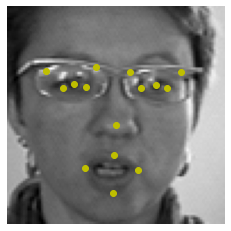

In [23]:
# visualization
ind = 10
plt.imshow(features[ind,:,:,0],cmap='gray')
plt.scatter(key_pts.iloc[ind][0:-1:2], key_pts.iloc[ind][1::2], c='y')
plt.axis('off')
plt.show()

In [24]:
x_train, x_test, y_train, y_test = train_test_split(features, key_pts, test_size = 0.2)

## 2. Model (CNN)

In [76]:
# params
img_size = 96
batch_size = 32
epochs = 200

In [77]:
model = Sequential()

model.add(Input(shape=(img_size, img_size, 1)))

model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding="same"))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding="same"))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding="same"))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(LeakyReLU(alpha = 0.1))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(LeakyReLU(alpha = 0.1))
model.add(Dense(30))

In [78]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_24 (Batc (None, 96, 96, 1)         4         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 64)      

In [79]:
model.compile(loss = 'mean_squared_error', optimizer = Adam(), 
              metrics=['mean_squared_error'])

## 3. Training

In [80]:
%%time
hist = model.fit(x_train, y_train,batch_size = batch_size, epochs = epochs, 
                 validation_data = (x_test, y_test), shuffle = True)

Epoch 1/200
177/177 [==============================] - 3s 14ms/step - loss: 504.1749 - mean_squared_error: 504.1749 - val_loss: 743.0502 - val_mean_squared_error: 743.0502
Epoch 2/200
177/177 [==============================] - 2s 12ms/step - loss: 240.4330 - mean_squared_error: 240.4330 - val_loss: 687.4585 - val_mean_squared_error: 687.4585
Epoch 3/200
177/177 [==============================] - 2s 13ms/step - loss: 198.1432 - mean_squared_error: 198.1432 - val_loss: 328.5437 - val_mean_squared_error: 328.5437
Epoch 4/200
177/177 [==============================] - 2s 12ms/step - loss: 161.6781 - mean_squared_error: 161.6781 - val_loss: 186.0420 - val_mean_squared_error: 186.0420
Epoch 5/200
177/177 [==============================] - 2s 12ms/step - loss: 146.7092 - mean_squared_error: 146.7092 - val_loss: 189.6750 - val_mean_squared_error: 189.6750
Epoch 6/200
177/177 [==============================] - 2s 14ms/step - loss: 130.9574 - mean_squared_error: 130.9574 - val_loss: 152.0472 - v

In [81]:
# Save model
model.save("/kaggle/working/landmark.h5")

landmark_json = model.to_json()

with open("/kaggle/working/landmark.json", "w") as json_file:
    json_file.write(landmark_json)

In [82]:
model = load_model('/kaggle/working/landmark.h5')

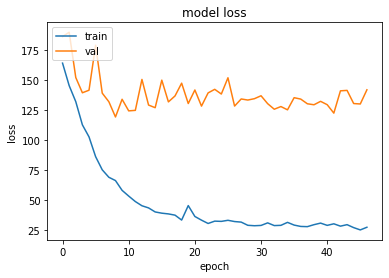

In [83]:
plt.plot(hist.history['loss'][3:50])
plt.plot(hist.history['val_loss'][3:50])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 4. Prediction

In [84]:
pred = model.predict(x_test)

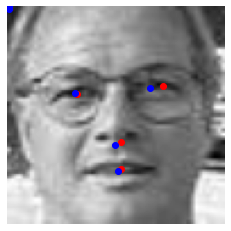

In [85]:
index = 100
pred_pt = np.array(y_test)[index]

plt.imshow(x_test[index,:,:,:], cmap='gray')
plt.scatter(pred_pt[0:-1:2], pred_pt[1::2], c='r')
plt.scatter(pred[index,:][0:-1:2],pred[index,:][1::2],c='b')
plt.axis('off')
plt.show()

### References
[1] Facial Landmark, https://www.kaggle.com/satyaprakash13820/facial-landmark